This notebook validates our emprically derived parametric function for predicting the mean distance between two Poisson spike trains of the same rate, give duration and cost parameter q.

Graphs at the end compare the parametrically estimated values to numerically estimated values, for firing rates not included in the training set used to fit the parametric function.

In [ ]:
# imports
import sys
import numpy as np  
from poisson_utils import generate_poisson_unit, poisson_spkd_estimate   
from tbc_computation import randSpkd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import plasma
from matplotlib.colors import Normalize


In [3]:
# === PARAMETERS ===
DURATION = 1.0  # Global constant
N = 500         # Number of repetitions per FR-cost pair
firing_rates = np.linspace(1, 100, 20)
cost_values = np.logspace(-3, 6, num=70)

The following cell is computationally expensive, so we have saved the results to a file and commented out the code; subsequent cells can load the file to avoid recomputing this.

In [ ]:
# # === OUTPUT STORAGE ===
# spkd_per_spike = np.zeros((len(cost_values), len(firing_rates)))
# spkd_per_sec = np.zeros_like(spkd_per_spike)

# # === SIMULATION LOOP ===
# for i, cost in enumerate(tqdm(cost_values, desc="Costs")):
#     for j, fr in enumerate(firing_rates):
#         # Simulate spike trains
#         spike_trains = generate_poisson_unit(fr, duration=DURATION, dt=1e-4, N=N)
        
#         # Compute SPKD
#         result = randSpkd(spike_trains, duration=DURATION, cost=cost)
#         mean_dist = result['mean']
        
#         # Store normalized values
#         spkd_per_spike[i, j] = mean_dist / (fr * DURATION)
#         spkd_per_sec[i, j] = mean_dist / DURATION


Costs: 100%|██████████| 70/70 [16:11<00:00, 13.88s/it]


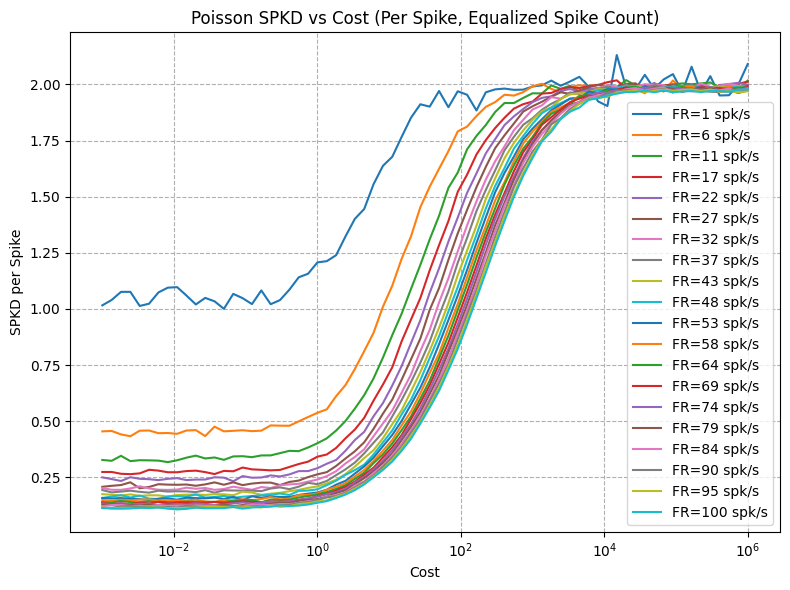

In [ ]:
# # === SAVE OUTPUT ===
# np.savez('spkd_poisson_equalized.npz',
#          firing_rates=firing_rates,
#          cost_values=cost_values,
#          spkd_per_spike=spkd_per_spike,
#          spkd_per_sec=spkd_per_sec)

In [4]:
spkd_data = np.load('spkd_poisson_equalized.npz', allow_pickle=True)
firing_rates, cost_values, spkd_per_spike, spkd_per_sec = (spkd_data['firing_rates'],
                                                          spkd_data['cost_values'],
                                                          spkd_data['spkd_per_spike'],
                                                          spkd_data['spkd_per_sec'])

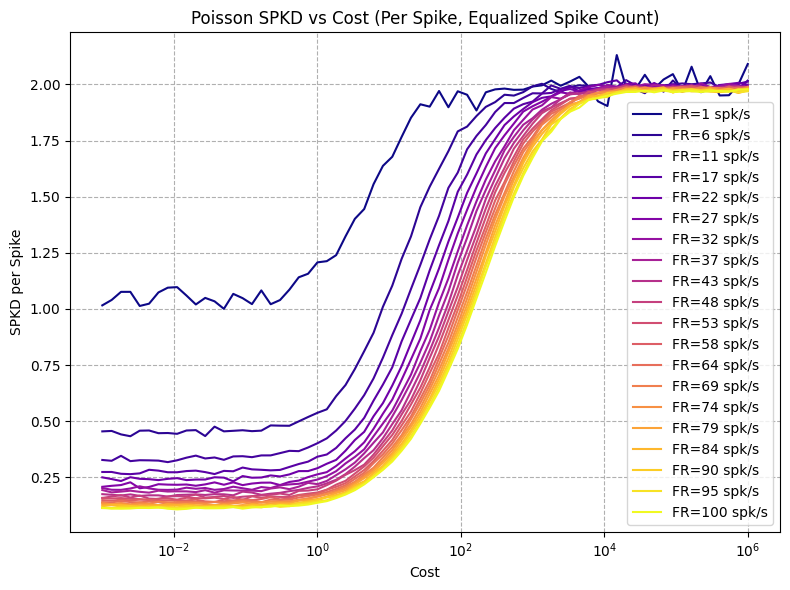

In [15]:
# === PLOT: SPKD per spike vs Cost with plasma colormap ===
plt.figure(figsize=(8, 6))

norm = Normalize(vmin=0, vmax=len(firing_rates) - 1)

for j, fr in enumerate(firing_rates):
    color = plasma(norm(j))
    plt.plot(cost_values, spkd_per_spike[:, j], label=f'FR={fr:.0f} spk/s', color=color)

plt.xscale('log')
plt.xlabel('Cost')
plt.ylabel('SPKD per Spike')
plt.title('Poisson SPKD vs Cost (Per Spike, Equalized Spike Count)')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.savefig('spkd_poisson_per_spike.png')
plt.show()


In [6]:
firing_rate_all = np.array([17.6       ,  5.78333333,  6.81666667])
np.array([poisson_spkd_estimate(fr, cost=1000000.0, output='per_spike', duration=1) for fr in firing_rate_all])


array([1.99986231, 1.99998132, 1.99997454])

In [ ]:
# === VALIDATION ===

FR_val = 55.5
cost_val = 5e-2
duration_val = 10
N_val = 100
dt = 1e-4

# Simulate Poisson spike trains and compute SPKD
spike_trains = generate_poisson_unit(FR_val, duration=duration_val, dt=dt, N=N_val)
result = randSpkd(spike_trains, duration=duration_val, cost=cost_val)
simulated_dist_raw = result['mean']
simulated_dist_sec = simulated_dist_raw / duration_val
simulated_dist_spk = simulated_dist_raw / (FR_val * duration_val)

# Compute parametric estimates
estimated_spkd_spike = poisson_spkd_estimate(FR=FR_val, cost=cost_val, output='per_spike')
estimated_spkd_sec = poisson_spkd_estimate(FR=FR_val, cost=cost_val, output='per_sec', duration=duration_val)

# --- comparison ---
print("=== Poisson SPKD Validation ===")
print(f"FR = {FR_val:.1f} spk/s, Cost = {cost_val:.3g}")
print(f"Simulated SPKD per spike: {simulated_dist_spk:.4f}")
print(f"Estimated  SPKD per spike: {estimated_spkd_spike:.4f}")
print()
print(f"Simulated SPKD per second: {simulated_dist_sec:.4f}")
print(f"Estimated  SPKD per second: {estimated_spkd_sec:.4f}")


=== Poisson SPKD Validation ===
FR = 55.5 spk/s, Cost = 0.05
Simulated SPKD per spike: 0.0507
Estimated  SPKD per spike: 0.1544

Simulated SPKD per second: 2.8117
Estimated  SPKD per second: 8.5713


Validating at FR=20.0: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]


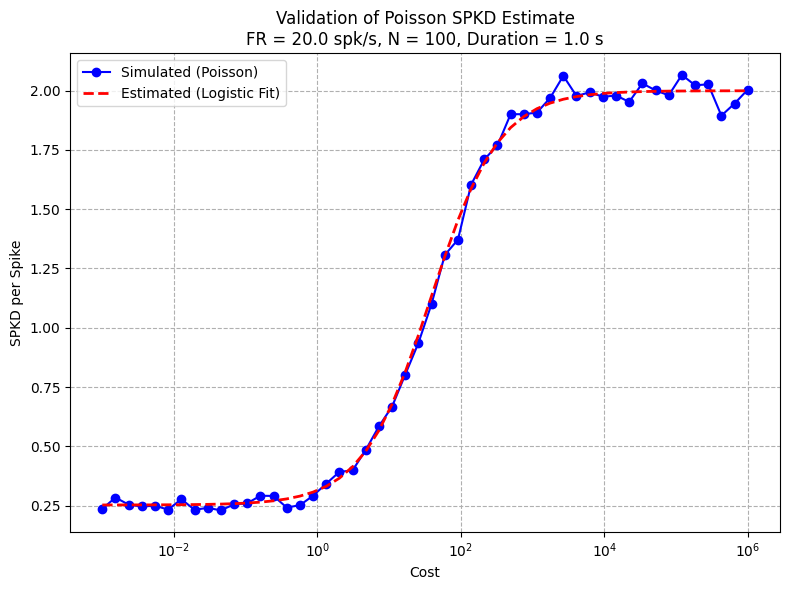

In [ ]:
# === VALIDATION PLOT ===

FR_val = 20
duration_val = 1
N_val = 100
dt = 1e-4

# Sweep across costs
cost_sweep = np.logspace(-3, 6, 50)

# Storage
sim_spkd_spike = []
est_spkd_spike = []

# Loop over costs
for cost in tqdm(cost_sweep, desc=f"Validating at FR={FR_val:.1f}"):
    # Simulate Poisson spike trains
    spike_trains = generate_poisson_unit(FR_val, duration=duration_val, dt=dt, N=N_val)
    result = randSpkd(spike_trains, duration=duration_val, cost=cost)
    
    # Normalize simulated distance per spike
    dist_spk = result['mean'] / (FR_val * duration_val)
    sim_spkd_spike.append(dist_spk)

    # Estimate using logistic model
    est = poisson_spkd_estimate(FR=FR_val, cost=cost, output='per_spike')
    est_spkd_spike.append(est)

# Convert to arrays
sim_spkd_spike = np.array(sim_spkd_spike)
est_spkd_spike = np.array(est_spkd_spike)

# === PLOT ===
plt.figure(figsize=(8, 6))

plt.plot(cost_sweep, sim_spkd_spike, marker='o', linestyle='-', color='blue', label='Simulated (Poisson)')
plt.plot(cost_sweep, est_spkd_spike, linestyle='--', color='red', linewidth=2, label='Estimated (Logistic Fit)')

plt.xscale('log')
plt.xlabel('Cost')
plt.ylabel('SPKD per Spike')
plt.title(f'Validation of Poisson SPKD Estimate\nFR = {FR_val:.1f} spk/s, N = {N_val}, Duration = {duration_val:.1f} s')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()


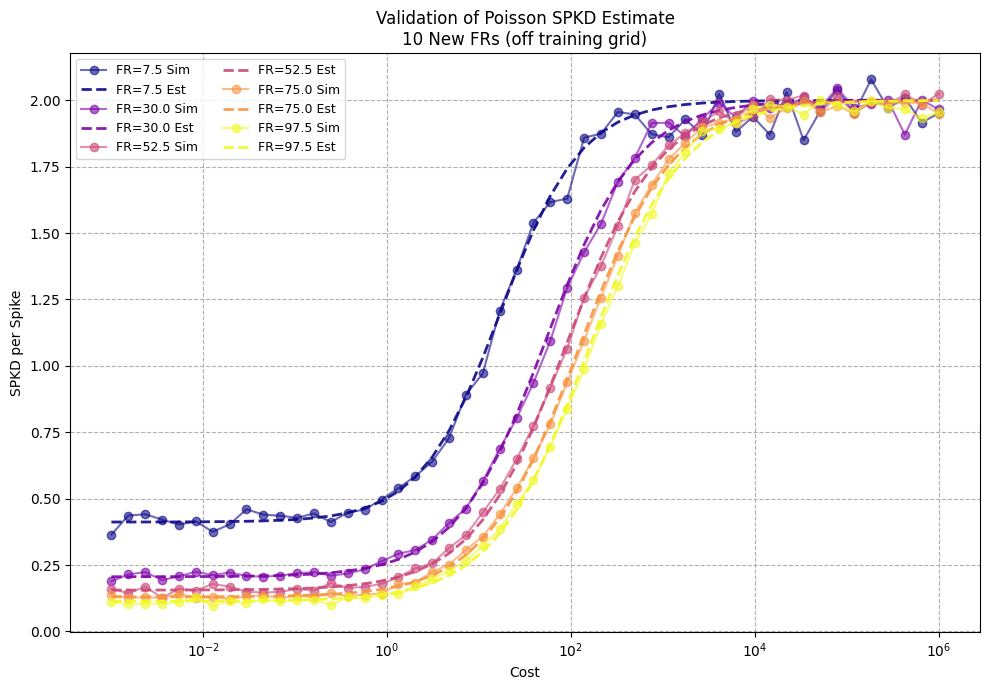

In [ ]:
# === MULTI-FR VALIDATION PLOT ===

# New FR values (off the training grid)
FR_vals = np.linspace(5, 95, 5) + 2.5  # [7.5, 17.5, ..., 97.5]
cost_sweep = np.logspace(-3, 6, 50)

duration_val = 1
N_val = 100
dt = 1e-4

# Plot setup
plt.figure(figsize=(10, 7))
colors = plt.cm.plasma(np.linspace(0, 1, len(FR_vals)))

# Loop over FRs
for idx, FR_val in enumerate(FR_vals):
    sim_spkd_spike = []
    est_spkd_spike = []

    for cost in cost_sweep:
        # Simulate Poisson spike trains
        spike_trains = generate_poisson_unit(FR_val, duration=duration_val, dt=dt, N=N_val)
        result = randSpkd(spike_trains, duration=duration_val, cost=cost)
        dist_spk = result['mean'] / (FR_val * duration_val)
        sim_spkd_spike.append(dist_spk)

        # Estimate using logistic model
        est = poisson_spkd_estimate(FR=FR_val, cost=cost, output='per_spike')
        est_spkd_spike.append(est)

    # Convert to arrays
    sim_spkd_spike = np.array(sim_spkd_spike)
    est_spkd_spike = np.array(est_spkd_spike)

    # Plot both
    plt.plot(cost_sweep, sim_spkd_spike, marker='o', linestyle='-', color=colors[idx], alpha=0.6,
             label=f'FR={FR_val:.1f} Sim')
    plt.plot(cost_sweep, est_spkd_spike, linestyle='--', color=colors[idx], linewidth=2, alpha=0.9,
             label=f'FR={FR_val:.1f} Est')

# Plot settings
plt.xscale('log')
plt.xlabel('Cost')
plt.ylabel('SPKD per Spike')
plt.title('Validation of Poisson SPKD Estimate\n10 New FRs (off training grid)')
plt.legend(ncol=2, fontsize=9)
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.savefig('spkd_poisson_multi_fr_validation.png')
plt.show()
